<a href="https://colab.research.google.com/github/jclary-31/VegetationFromSpace_Landsat2_Sentinel8/blob/main/Multispectral_Satellite_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='landsat-test01')


In [140]:
lat=37
lon=-6
centralloc = ee.Geometry.Point([lon,lat])  # Adjust coordinates if more precise data is available

region = ee.Geometry.Rectangle([lon-2, lat-1, lon+2, lat+1])

date_i='2020-07-01'
date_f='2020-09-01'
dates=(date_i,date_f)

# Applies scaling factors.
def Landsat_apply_factors(image):
  '''
   Apply scale factors to Landsat 8
   function taken on earh engine Data catalog for landsat T1_L2
  '''
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, overwrite=True).addBands(
      thermal_bands, None, overwrite=True
  )

def  getCollection(sat,dates,region):
    if sat=='era5':
        sat_id='ECMWF/ERA5_LAND/HOURLY' #land hourly data ; weather related data
    elif sat=='landsat':
        sat_id= 'LANDSAT/LC08/C02/T1_L2'#  Landsat 8, collection 2, niveau 1 uniquement
    elif sat=='sentinel':
        sat_id='COPERNICUS/S2_HARMONIZED' #the harmonized prodcut, better?
    else:
        print('no Sat')
        return
    #
    mySat= ee.ImageCollection(sat_id)\
        .filterDate(dates[0],dates[1]) \
        .filterBounds(region) \
        #.filter(ee.Filter.listContains('system:time_start'))
        #.first()#Returns the first entry from a given collection. for test


    #if landsat scaleing factors must be applied on the whole collection
    if sat_id=='landsat':
      mySat=mySat.map(Landsat_apply_factors)

        #era5 is reanalisys bit other 2 are realobs with cloud
    #A60 band is used for cloud mask per pixel (60m)
    if sat_id=='sentinel':
      #keep image with less than x% of cloud / remove too cloudy images
        mySat=mySat.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))
    return mySat


#Era5=getCollection('era5',dates,region)
Landsat=getCollection('landsat',dates,region)
Sentinel=getCollection('sentinel',dates,region)

def Sent_QAmask(image):
  #remove pixel with bad quality and pixel with cloud
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) \
    and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask)#.divide(10000)


def Land_QAmask(image):
  #remove pixel with bad quality and pixel with cloud
  #see https://developers.google.com/earth-engine/tutorials/community/time-series-modeling
  #see https://gis.stackexchange.com/questions/405056/understanding-the-cloud-mask-in-google-earth-engine
    quality_band = image.select('QA_PIXEL')
    cloudmask = 1 << 4
    cloudshadowmask = 1 << 5
    mask = quality_band.bitwiseAnd(cloudshadowmask).eq(0) \
    and (quality_band.bitwiseAnd(cloudmask).eq(0))
    return image.updateMask(mask)


Landsat=Landsat.map(Land_QAmask)
Sentinel=Sentinel.map(Sent_QAmask)



####################BANDS and spectral index

#sentinel bands
codes = ['QA60','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']
names = ['QA60','blue','green','red','re1','re2','re3','nir','re4','waterVapor','cirrus','swir1','swir2']

S_BAND=dict([(n,c) for c,n in zip(codes,names)])

#landsat 8 bands
codes=['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
names=['Coastal','blue','green','red','nir','swir1','swir2'] # Ithink
L8_BAND=dict([(n,c) for c,n in zip(codes,names)])


def compute_ndvi(image):
    #Normalized Difference Vegetation Index
    #photosynthetically active biomass / vegetation health
    #NDVI = (NIR-RED)/(NIR+RED)
    ndvi = image.normalizedDifference([BAND['nir'], BAND['red']]).rename('NDVI')
    return image.addBands(ndvi)


BAND=L8_BAND
Landsat=Landsat.map(compute_ndvi)

BAND=S_BAND
Sentinel=Sentinel.map(compute_ndvi)






palette0=[ 'yellow', 'green','blue']
palette1 = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']
#vis_params = {"min":0.0, "max":1,"palette": ['B4','B3','B2']}
vis_params={'min': -0.2, 'max': .5,
            'palette': palette1}


#Map = geemap.Map(center=[lat, lon],zoom=6)

#image.getInfo()

In [141]:
image=Landsat.median().clip(region)


Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select('NDVI'), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map


Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [142]:
image=Sentinel.median().clip(region)


Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select('NDVI'), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map



Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [150]:
image.bandNames().getInfo()


Minmax=image.select('B8').reduceRegion(ee.Reducer.minMax(),geometry=region).values().getInfo()
print (Minmax)

#Sentinel.toList(4).getInfo()[0]['properties']

[2866, 288]


In [156]:
# Visualisation with false color for Sentinel
# see https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/

image_viz_params = {
    'bands': ['B8', 'B4', 'B3'],
    'min': 0,
    'max': 3500,
    'gamma': [0.95, 1.1, 1],
}

# Define a map centereon area of interest
Map = geemap.Map()
Map.centerObject(region, 8)
Map.add_layer(image, image_viz_params, 'false color composite')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map



Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

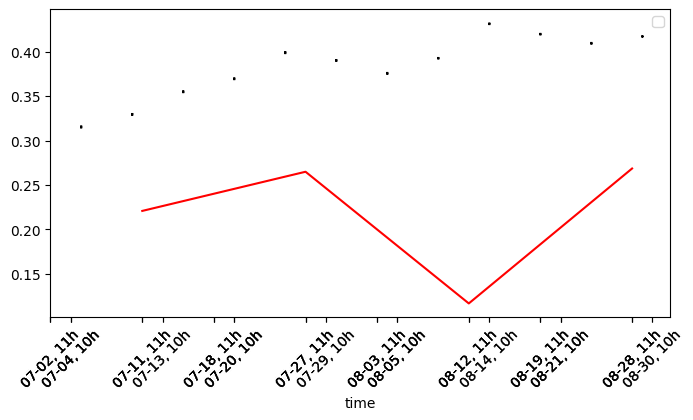

In [157]:
import matplotlib.pyplot as plt
import pandas as pd

poi = ee.Geometry.Point(lon,lat).buffer(1000) #point of interest with 500m buffer circle area



def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('mean',mean)


def poi_std(img):
    mean = img.reduceRegion(reducer=ee.Reducer.stdDev(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('std',std)



def ImageColl_toDataFrame(ImageCollection,poi,method):
    #
    if method=='mean':
        ImageColl_=ImageCollection.map(poi_mean)
    elif method=='std':
        ImageColl_=ImageCollection.map(poi_std)
    #
    reduced=ImageColl_.reduceColumns(ee.Reducer.toList(2), ['date',method]).values().get(0)
    data_sat=reduced.getInfo()
    #
    Df=dataSat_toDataFrame(data_sat)
    return Df


def dataSat_toDataFrame(data_sat):
    Q=pd.DataFrame()
    for i in range(len(data_sat)):
        time=data_sat[i][0]
        data=data_sat[i][1]
        q=pd.DataFrame.from_dict(data,orient='index').T
        q['time']=time
        Q=pd.concat([Q,q])
    #
    Q.index=Q.pop('time')
    return Q


method='mean'
Land_df=ImageColl_toDataFrame(Landsat,poi,method)
Sent_df=ImageColl_toDataFrame(Sentinel,poi,method)


feature='NDVI'

#convertindex in timeline
Land_time=pd.to_datetime(Land_df.index,utc=True)
Sent_time=pd.to_datetime(Sent_df.index,utc=True)

#timeserie
timeformat='%m-%d, %Hh'
timelabel=[x.strftime(timeformat) for x in Land_time]#less timestamp with landsat

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(Land_time,Land_df[feature],'r')
ax.plot(Sent_time,Sent_df[feature],'k')
ax.legend('Landsat8','Sentinel2')
ax.set_xlabel('time')
ax.set_xticks(Land_time, labels=timelabel)
ax.tick_params(axis='x', labelrotation=45)
ax
fig.show()

